# Elastic Optical Network - Pre-Disaster Simulation Analysis (Refactored)

This notebook has been refactored to use modular analysis and visualization packages:

## Modules Used:

### Analysis (`simulador.analysis`)
- **`topology_analysis`**: Network structure analysis, critical disaster nodes
- **`metrics_calculator`**: Availability, blocking rates, performance metrics
- **`dataframe_filters`**: Data filtering by time, node, distance, components
- **`reporters`**: Formatted console output and reports

### Visualization (`simulador.visualization`)
- **`availability_plots`**: Availability charts and heatmaps
- **`traffic_plots`**: Traffic patterns and blocking visualizations

## Improvements:
- ✅ All inline functions removed
- ✅ Code reusable across notebooks
- ✅ Type hints and documentation
- ✅ Cleaner, more maintainable code

---


In [1]:
# Standard library
import math
import pickle
from collections import defaultdict

# Third-party
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from simpy import Environment

# Simulador - Core
from simulador import analysis
from simulador.main import Simulator
from simulador import Scenario, ScenarioGenerator, Metrics
from simulador.config.settings import NUMERO_DE_REQUISICOES, NUMERO_DE_SLOTS
from simulador import routing

# Simulador - Analysis
from simulador import analysis, visualization

# Simulador - Visualization
from simulador.visualization import (
    availability_plots,
    traffic_plots,
)

# Jupyter configuration
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Load topology
TOPOLOGY = nx.read_weighted_edgelist("topology/usa", nodetype=int)

print("✓ All modules loaded successfully!")


✓ All modules loaded successfully!


### Encontra bons pontos de desastre para topologia

In [2]:
# Use topology analysis from module
results = analysis.topology_analysis.find_balanced_min_cut_for_all_nodes(TOPOLOGY)

# Extract critical node info from results
critical_info = results[0]
NODE_DESASTRE = critical_info["node"]
COMPONENTE_1 = critical_info["partitions"][0]["partition_1"]
COMPONENTE_2 = critical_info["partitions"][0]["partition_2"]
CRITICAL_EDGES = critical_info["partitions"][0]["cut_edges"]

# Print analysis
analysis.topology_analysis.print_topology_analysis_results(results[:5])

print(f"\nSelected disaster node: {NODE_DESASTRE}")
print(f"Component 1: {len(COMPONENTE_1)} nodes")
print(f"Component 2: {len(COMPONENTE_2)} nodes")
print(f"Critical edges: {len(CRITICAL_EDGES)}")


Node 9 removed: min_cut = 2, size_diff = 7
  Cut edges: [(6, 11), (8, 10)]
  Partition 1: [1, 2, 3, 4, 5, 6, 7, 8]
  Partition 2: [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


Node 7 removed: min_cut = 2, size_diff = 15
  Cut edges: [(2, 3), (8, 10)]
  Partition 1: [8, 3, 4, 5]
  Partition 2: [1, 2, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


Node 17 removed: min_cut = 2, size_diff = 17
  Cut edges: [(14, 18), (22, 23)]
  Partition 1: [24, 18, 23]
  Partition 2: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 19, 20, 21, 22]


Node 6 removed: min_cut = 1, size_diff = 19
  Cut edges: [(2, 3)]
  Partition 1: [1, 2]
  Partition 2: [3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


Node 3 removed: min_cut = 2, size_diff = 19
  Cut edges: [(1, 6), (2, 6)]
  Partition 1: [1, 2]
  Partition 2: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]
  Cut edges: [(7, 4), (5, 8)]
  Partition 1:

### Cria cenario

In [3]:
criar_e_rodar_novo_cenario = True
is_logger_active = True

In [4]:
if criar_e_rodar_novo_cenario:
    roteamentos_a_serem_testados = [
        # routing.FirstFit,
        # routing.FirstFitDisasterAware,
        routing.FirstFitSubnet,
        routing.FirstFitSubnetDisasterAware,
    ]

    cenario1, cenario2 = ScenarioGenerator.gerar_cenarios(
        TOPOLOGY,
        retorna_lista_de_requisicoes=True,
        numero_de_requisicoes=NUMERO_DE_REQUISICOES,
        lista_de_roteamentos_de_desastre=roteamentos_a_serem_testados,
        disaster_node=NODE_DESASTRE,
    )

    # Save scenarios
    with open("output/cenario1.pkl", "wb") as file:
        pickle.dump(cenario1, file)

    with open("output/cenario2.pkl", "wb") as file:
        pickle.dump(cenario2, file)
else:
    # Load existing scenarios
    with open("output/cenario1.pkl", "rb") as file:
        cenario1 = pickle.load(file)

    with open("output/cenario2.pkl", "rb") as file:
        cenario2 = pickle.load(file)


Link  9 6  vai falhar
Link  9 7  vai falhar
Link  9 10  vai falhar
Link  9 6  vai falhar
Link  9 7  vai falhar
Link  9 10  vai falhar
Link  9 11  vai falhar
Link  9 12  vai falhar
node_desastre 9


### Roda cenarios

In [5]:
cenario1.desastre.list_of_dict_node_per_start_time

[{'tipo': 'node', 'node': 9, 'start_time': 10}]

In [6]:
if criar_e_rodar_novo_cenario:
    # roda cenario1
    Metrics.reseta_registrador()
    env = Environment()
    simulador: Simulator = Simulator(
        env=env, topology=TOPOLOGY, status_logger=is_logger_active, cenario=cenario1
    )
    simulador.run()
    dataframe_cenario1 = simulador.salvar_dataframe("output/df_cenario1")
    dataframe_sliding_window = Metrics.cria_dataframe_janela_deslizante(
        "output/dataset1"
    )
    dataframe_media_disponibilidade_extra_componente = (
        Metrics.cria_dataframe_media_taxa_de_disponibilidade_extra_componente(
            "output/dataset1"
        )
    )
    dataframe_bloqueio_artificial = Metrics.cria_dataframe_bloqueio_artificial(
        "output/dataset1"
    )
dataframe1: pd.DataFrame = pd.read_csv("output/df_cenario1.csv")


10000 requests processed, time : 60
20000 requests processed, time : 120
30000 requests processed, time : 180
ISP 4 iniciando migração de 9 para 1 no tempo 202
ISP 2 iniciando migração de 9 para 20 no tempo 204
40000 requests processed, time : 236
Status ISP 4, 10% da migração concluída no tempo 245
ISP 0 iniciando migração de 9 para 23 no tempo 248
ISP 3 iniciando migração de 9 para 17 no tempo 259
50000 requests processed, time : 283
Status ISP 4, 20% da migração concluída no tempo 298
ISP 1 iniciando migração de 9 para 5 no tempo 301
60000 requests processed, time : 327
Status ISP 4, 30% da migração concluída no tempo 331
Status ISP 1, 10% da migração concluída no tempo 356
70000 requests processed, time : 371
Status ISP 4, 40% da migração concluída no tempo 404
80000 requests processed, time : 413
Status ISP 1, 20% da migração concluída no tempo 431
Status ISP 2, 10% da migração concluída no tempo 435
Status ISP 4, 50% da migração concluída no tempo 448
90000 requests processed, ti

/var/folders/0k/s6m7zdf54hgbxnlcw473w_1h0000gq/T/ipykernel_67431/1469711314.py:21: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe1: pd.DataFrame = pd.read_csv("output/df_cenario1.csv")


In [7]:
if criar_e_rodar_novo_cenario:
    # roda cenario2
    env = Environment()
    Metrics.reseta_registrador()
    simulador: Simulator = Simulator(
        env=env, topology=TOPOLOGY, status_logger=is_logger_active, cenario=cenario2
    )
    simulador.run()
    dataframe2_sliding_window = Metrics.cria_dataframe_janela_deslizante(
        "output/dataset2"
    )
    dataframe2_media_disponibilidade_extra_componente = (
        Metrics.cria_dataframe_media_taxa_de_disponibilidade_extra_componente(
            "output/dataset2"
        )
    )
    dataframe_cenario2 = simulador.salvar_dataframe("output/df_cenario2")
    dataframe2_bloqueio_artificial = Metrics.cria_dataframe_bloqueio_artificial(
        "output/dataframe2"
    )


dataframe2: pd.DataFrame = pd.read_csv("output/df_cenario2.csv")

10000 requests processed, time : 60
20000 requests processed, time : 120
30000 requests processed, time : 180
ISP 4 iniciando migração de 9 para 1 no tempo 202
ISP 2 iniciando migração de 9 para 20 no tempo 204
40000 requests processed, time : 236
ISP 0 iniciando migração de 9 para 23 no tempo 248
ISP 3 iniciando migração de 9 para 17 no tempo 259
50000 requests processed, time : 283
ISP 1 iniciando migração de 9 para 5 no tempo 301
60000 requests processed, time : 327
70000 requests processed, time : 371
80000 requests processed, time : 413
90000 requests processed, time : 456
100000 requests processed, time : 499
110000 requests processed, time : 542
Link 9 -> 6 falhou no tempo 564
ISP 1 finalizou migração no tempo 564, 0.0% da migração concluída
ISP 4 finalizou migração no tempo 564, 0.0% da migração concluída
ISP 0 finalizou migração no tempo 565, 0.0% da migração concluída
ISP 3 finalizou migração no tempo 566, 0.0% da migração concluída
ISP 2 finalizou migração no tempo 567, 0.0%

In [8]:
# Define disaster timing constants

DISASTER_START = cenario1.desastre.start

DISASTER_END = cenario1.desastre.start + cenario1.desastre.duration

print(f"Disaster period: {DISASTER_START} - {DISASTER_END}")


Disaster period: 564.0930111488473 - 768.1960814078828


In [9]:
ACTION_START_TIME = {
    isp.isp_id: isp.datacenter.tempo_de_reacao for isp in cenario1.lista_de_isps
}
DISASTER_START_TIME = min(
    [(isp.datacenter.tempo_de_reacao, isp.isp_id) for isp in cenario1.lista_de_isps]
)[0]
DISASTER_END_TIME = cenario1.desastre.start + cenario1.desastre.duration

/Users/claudio.faria/Library/Caches/pypoetry/virtualenvs/simulador-eon-pre-desastre-cLZF9wpT-py3.12/lib/python3.12/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


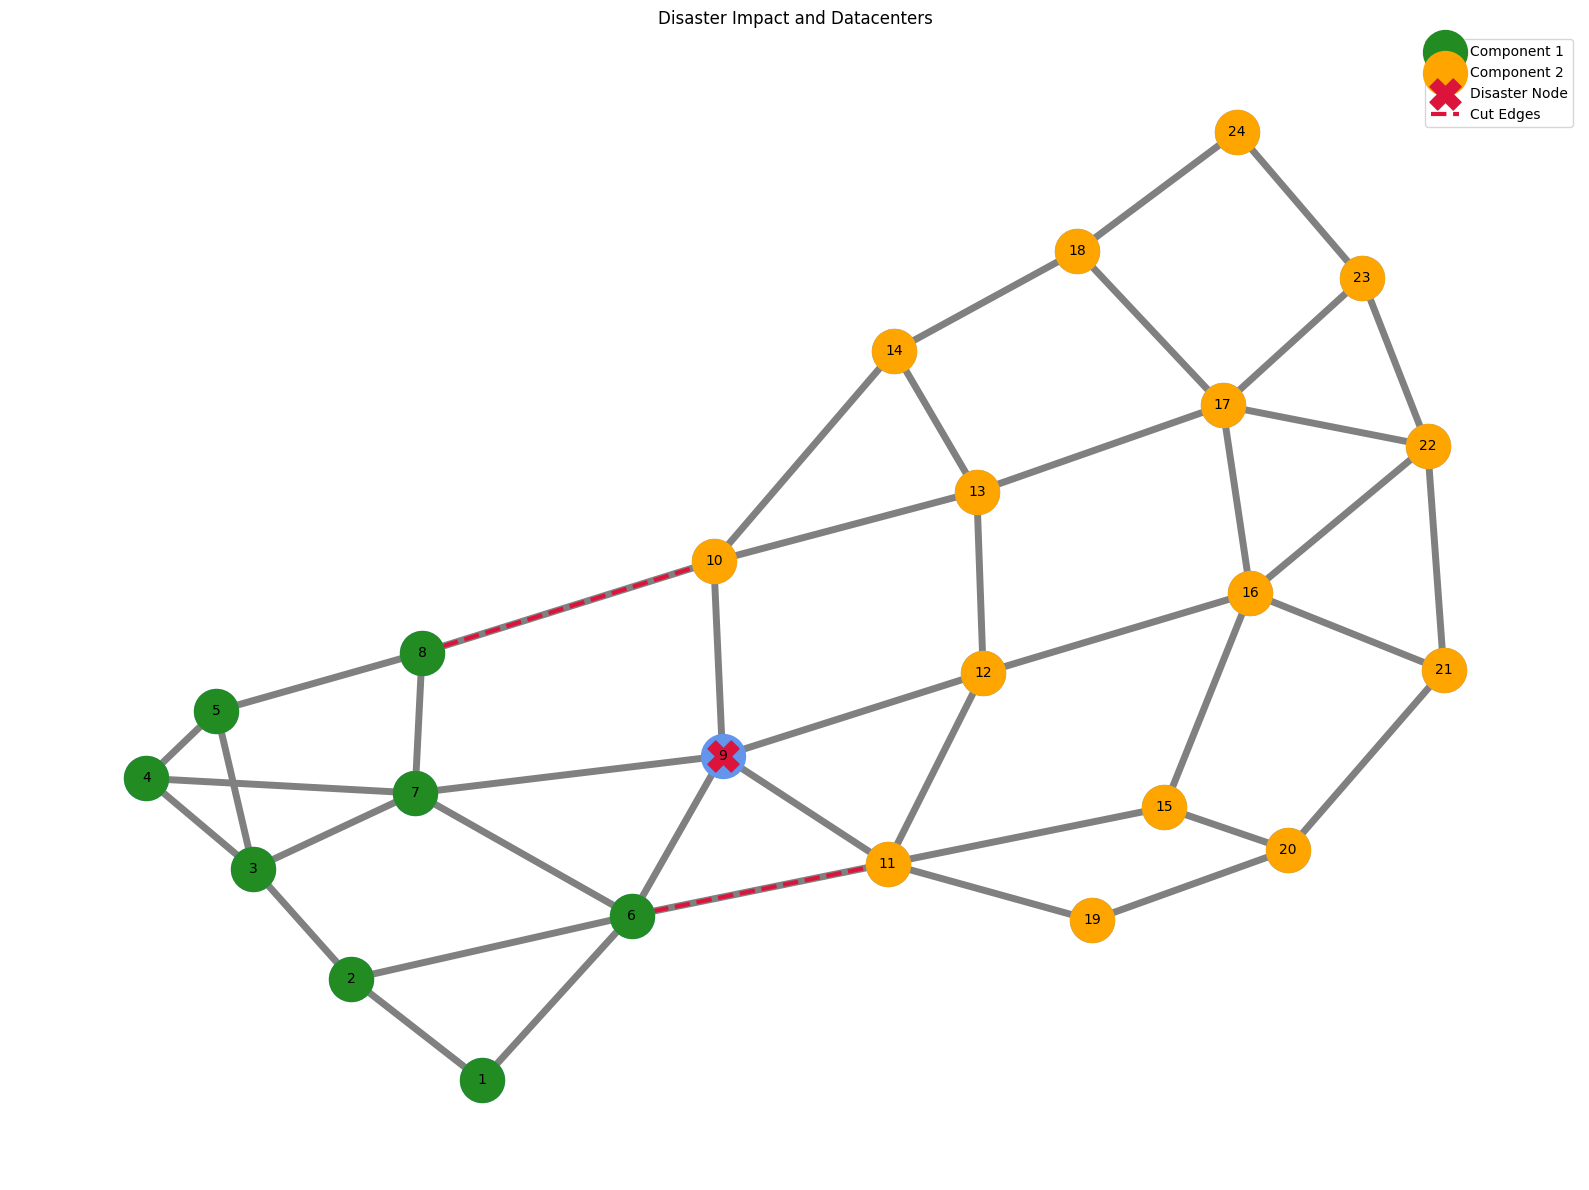

In [10]:
visualization.topology_plots.plot_disaster_and_datacenters(
    TOPOLOGY,
    disaster_node=NODE_DESASTRE,
    disaster_edges=CRITICAL_EDGES,
    components=(COMPONENTE_1, COMPONENTE_2)
)
plt.show()

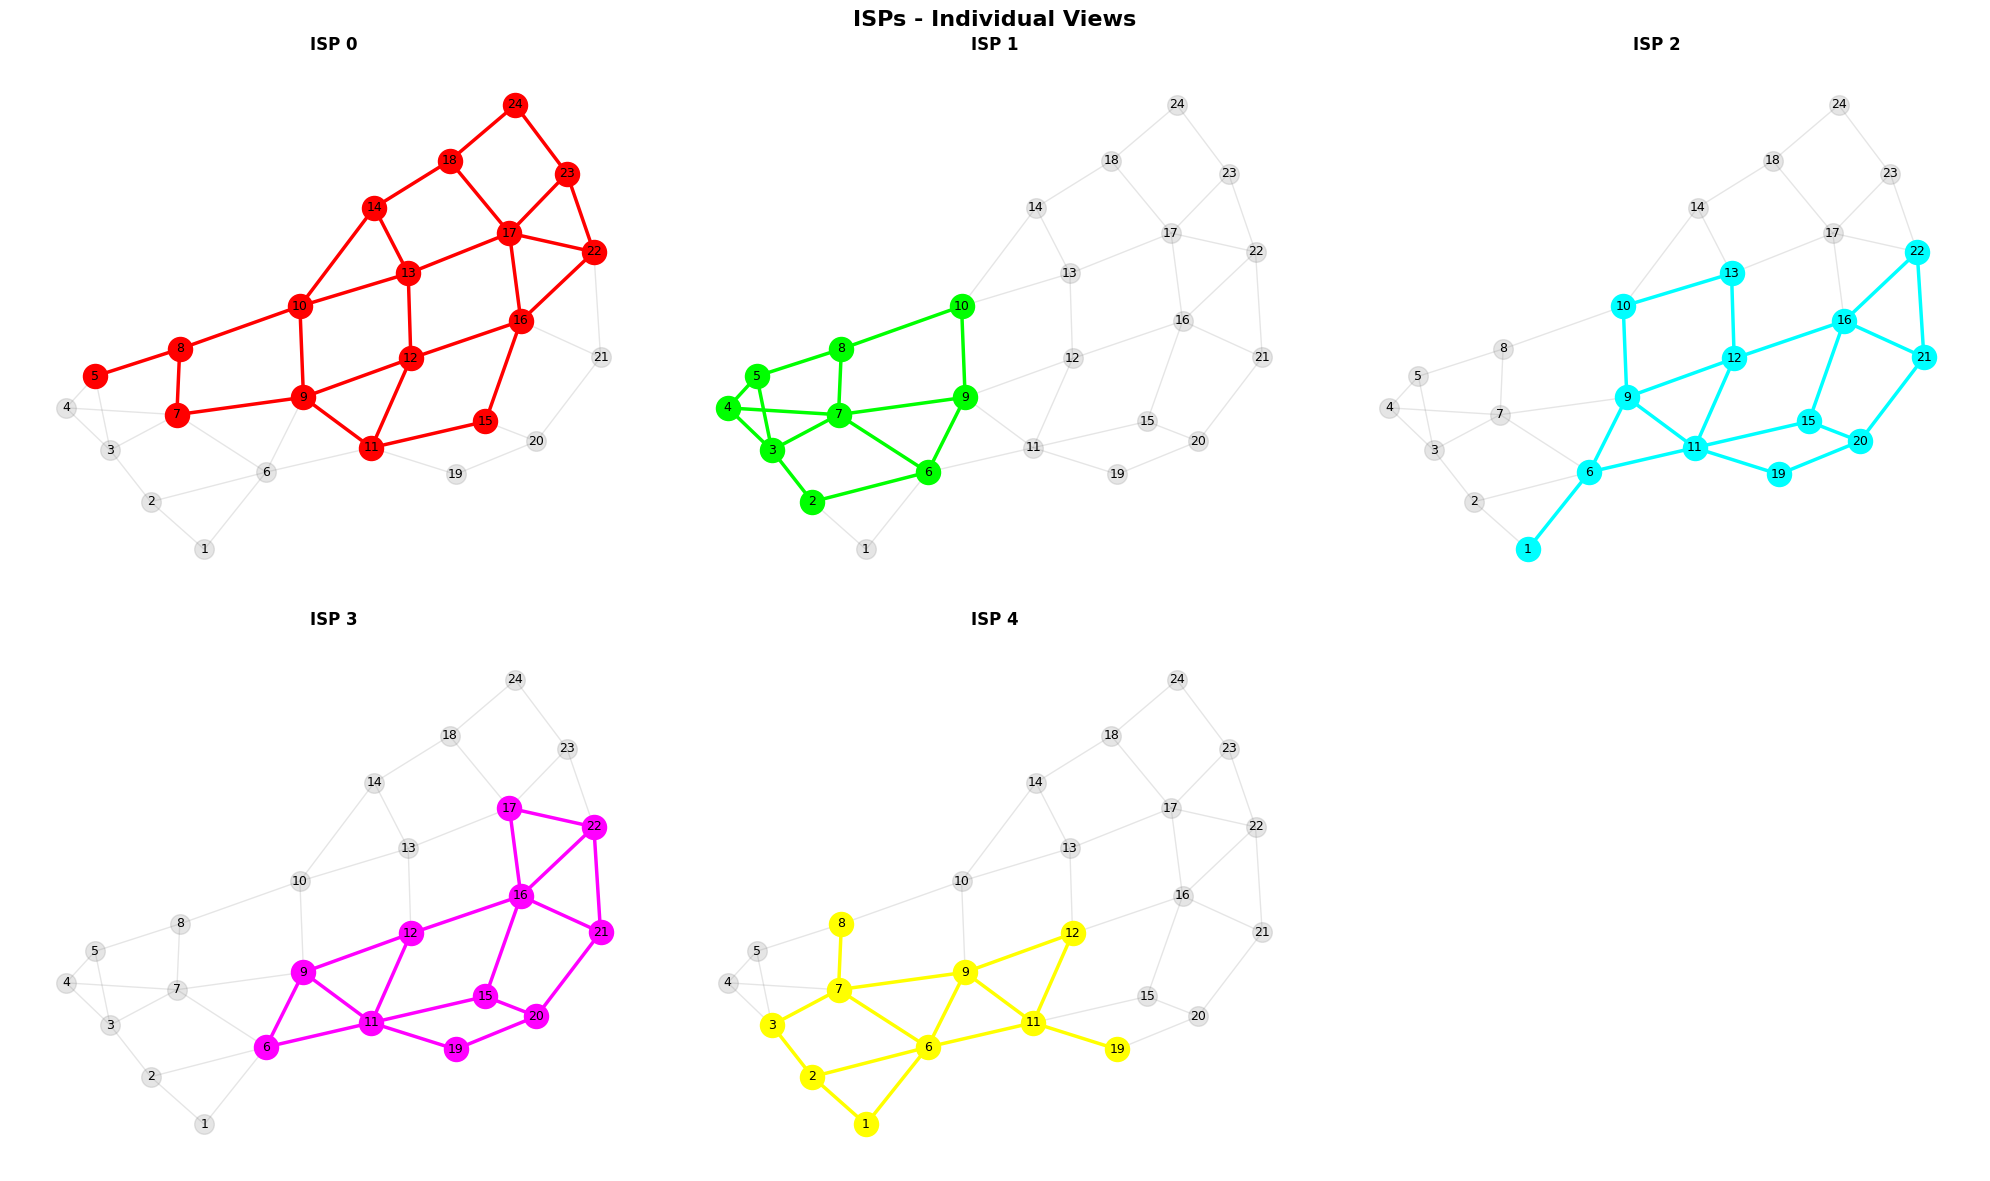

In [11]:
visualization.topology_plots.plot_isps_separately(
    TOPOLOGY,
    isp_data=cenario1,
    seed=7
)

### Plotagem de Dados Finais

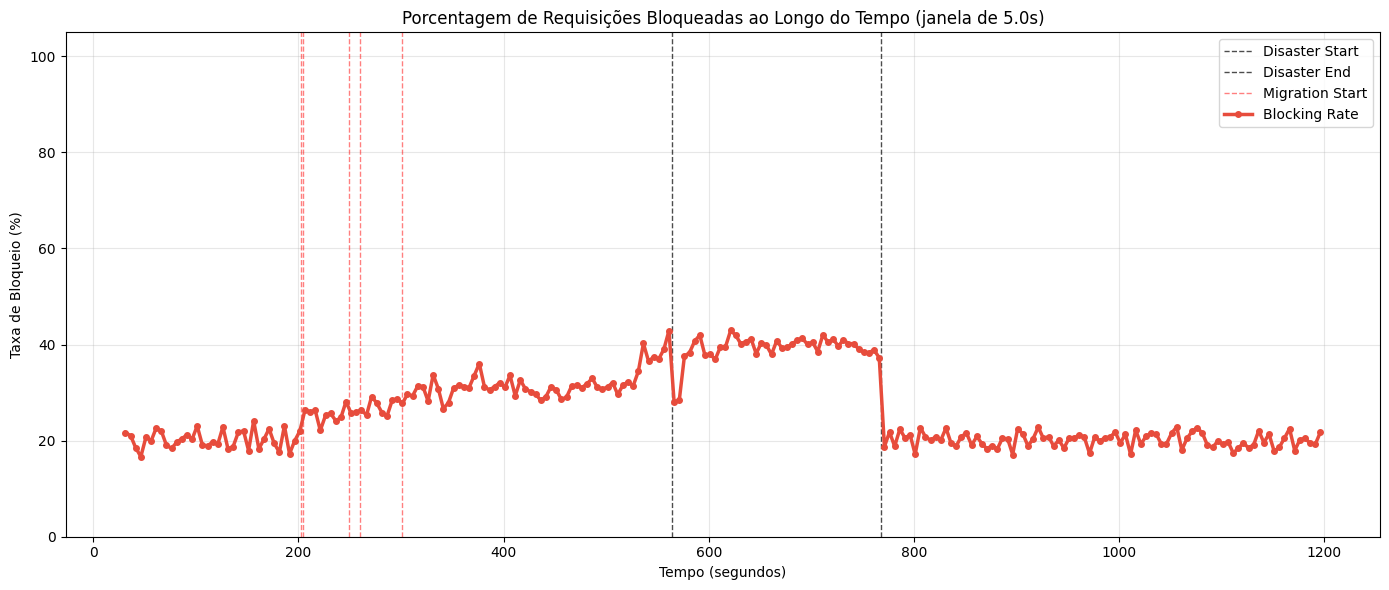

In [12]:
visualization.traffic_plots.plot_blocking_percentage_over_time(
    dataframe1,
    scenario=cenario1,

)

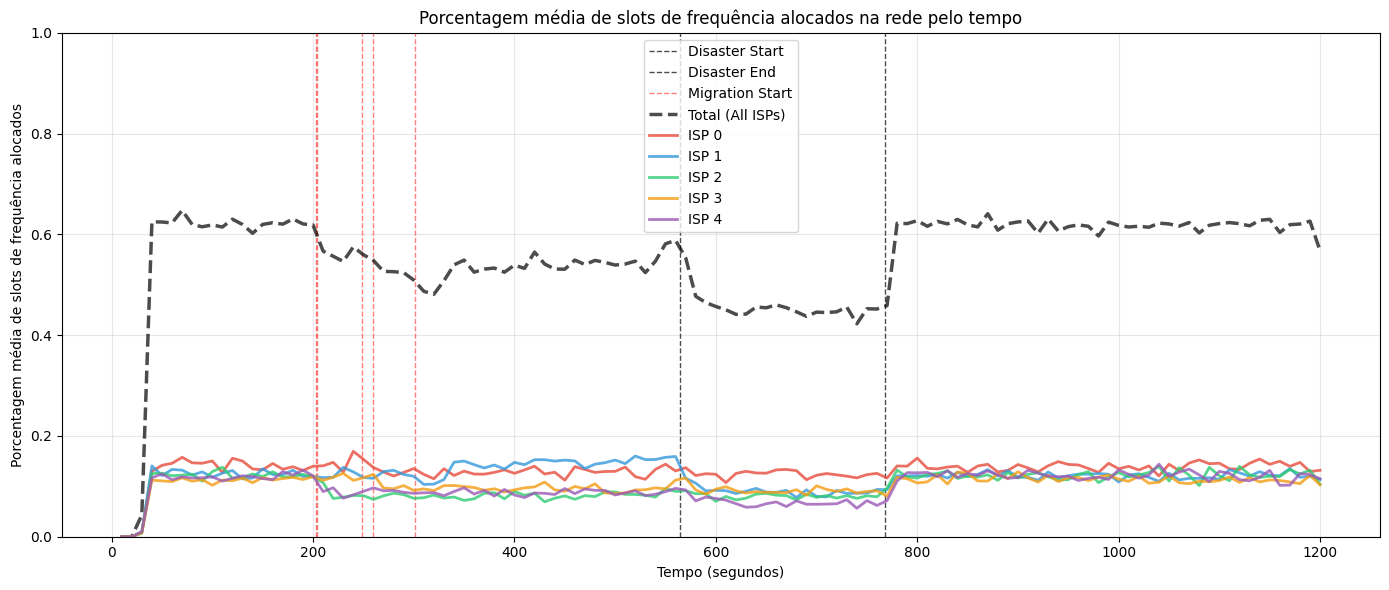

In [13]:
visualization.traffic_plots.plot_network_usage(dataframe1, TOPOLOGY, NUMERO_DE_SLOTS, scenario=cenario1, show_per_isp=True, )

In [14]:
len(dataframe1[(dataframe1["bloqueada"] == False) & (dataframe1["requisicao_de_migracao"] == True)])/len(dataframe1[(dataframe1["bloqueada"] == True) & (dataframe1["requisicao_de_migracao"] == True)])

0.7267057960381511

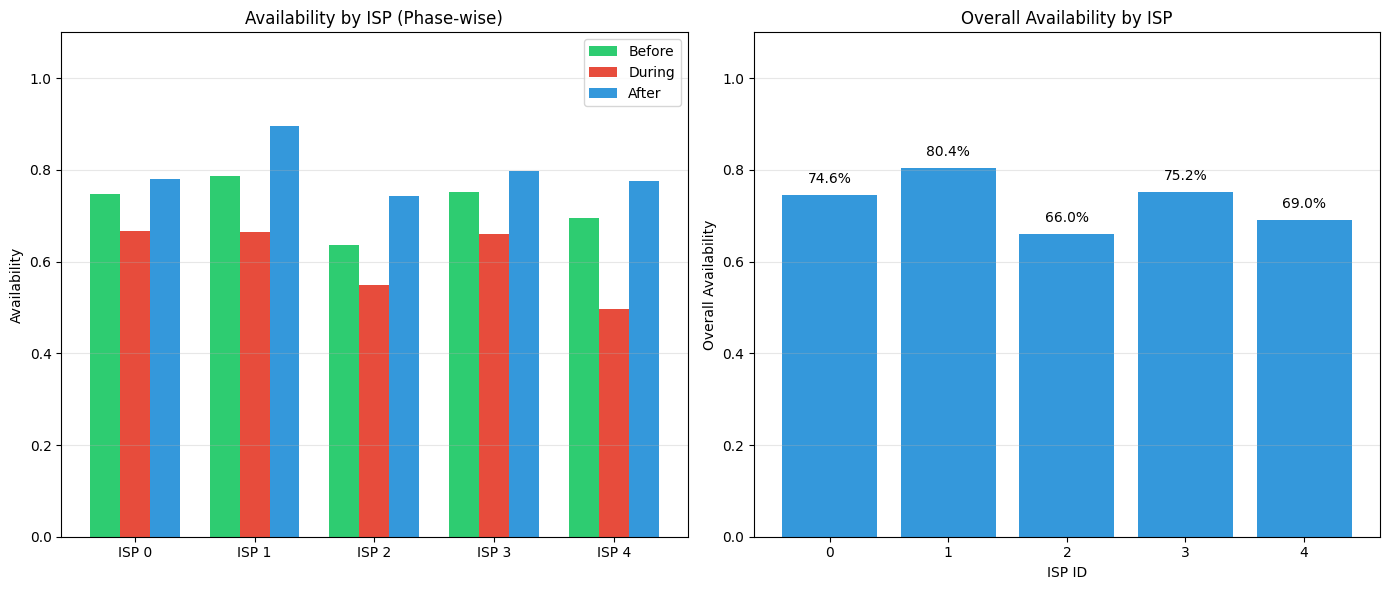

In [15]:
visualization.availability_plots.plot_availability_by_isp(dataframe1, cenario1, DISASTER_START, DISASTER_END)
#visualization.availability_plots.plot_isp_traffic_comparison(dataframe1, cenario1)

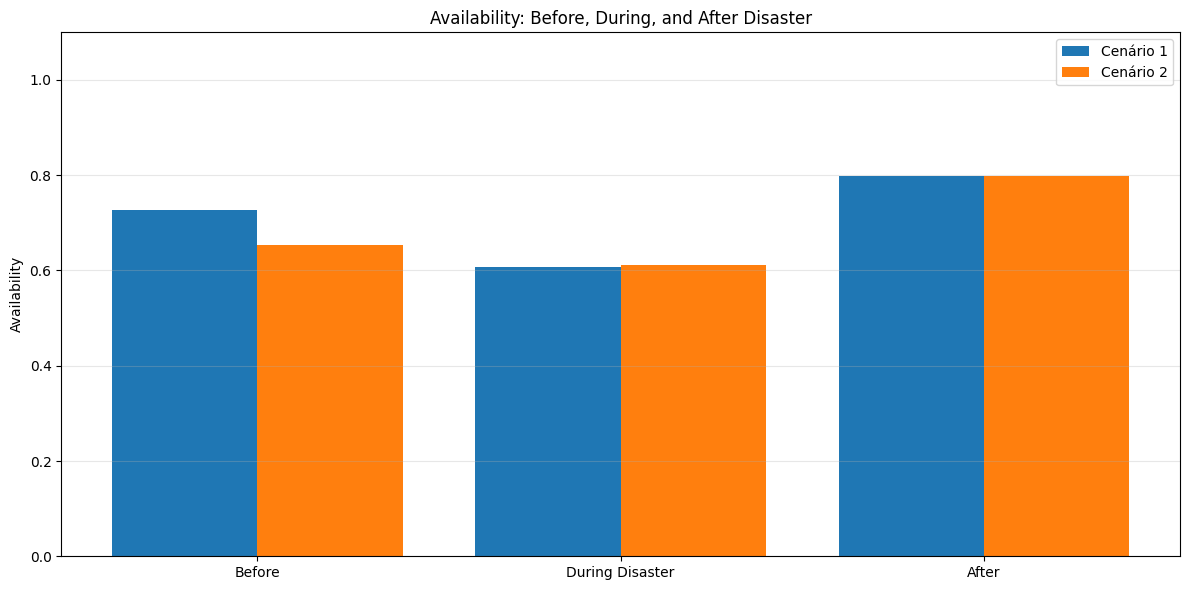

In [16]:
visualization.availability_plots.plot_availability_before_during_after({"Cenário 1": dataframe1, "Cenário 2": dataframe2}, DISASTER_START, DISASTER_END)

plt.show()


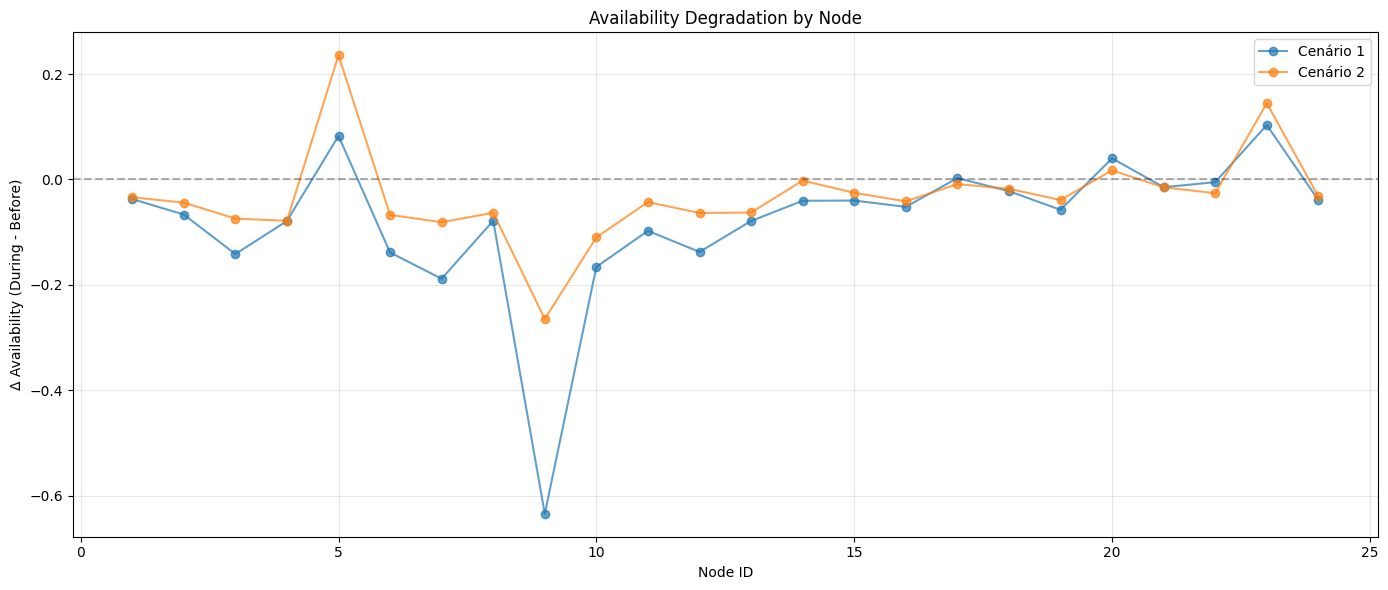

In [17]:
visualization.availability_plots.plot_delta_availability({"Cenário 1": dataframe1, "Cenário 2": dataframe2}, DISASTER_START, DISASTER_END)

plt.show()


In [23]:
visualization.traffic_plots.plot_network_usage(dataframe1, TOPOLOGY, scenario=cenario1)

TypeError: plot_network_usage() missing 1 required positional argument: 'numero_de_slots'

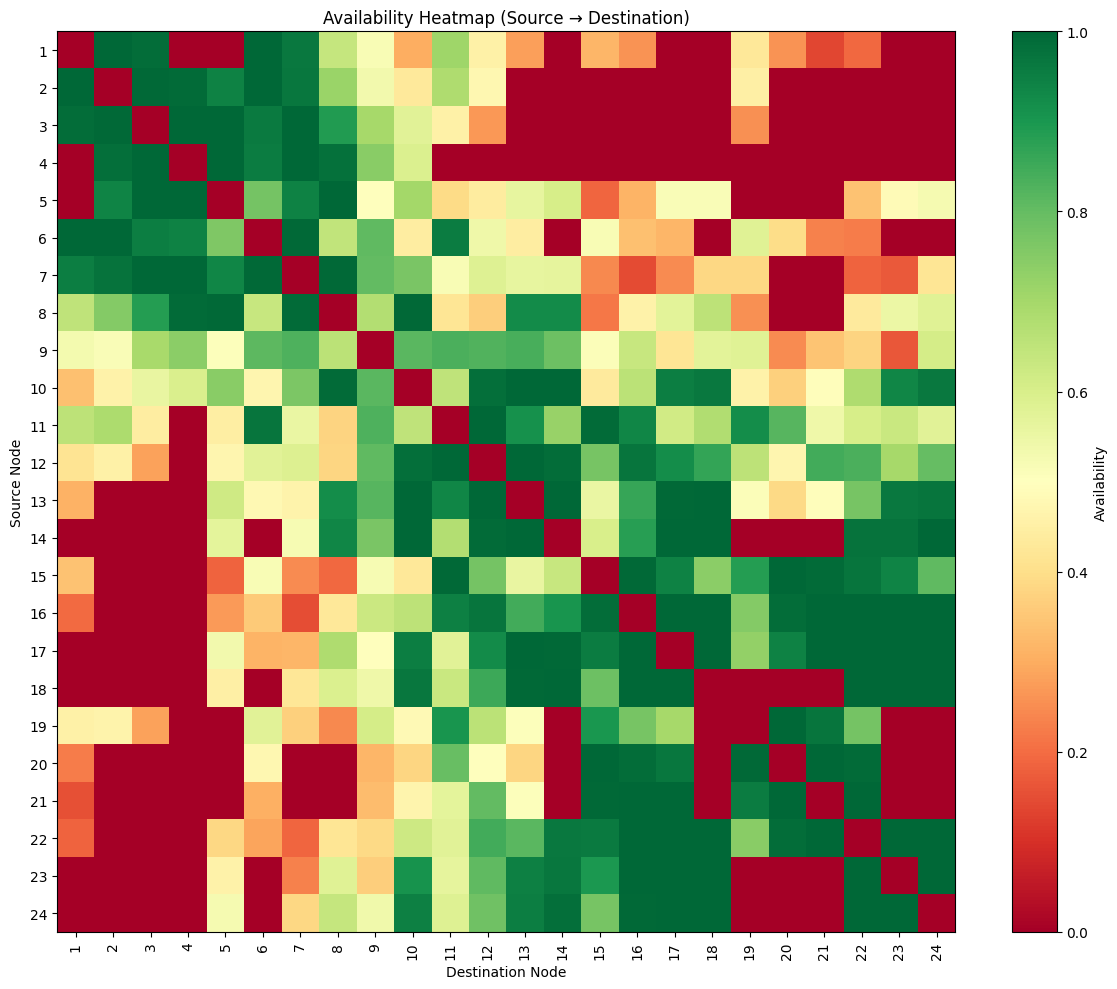

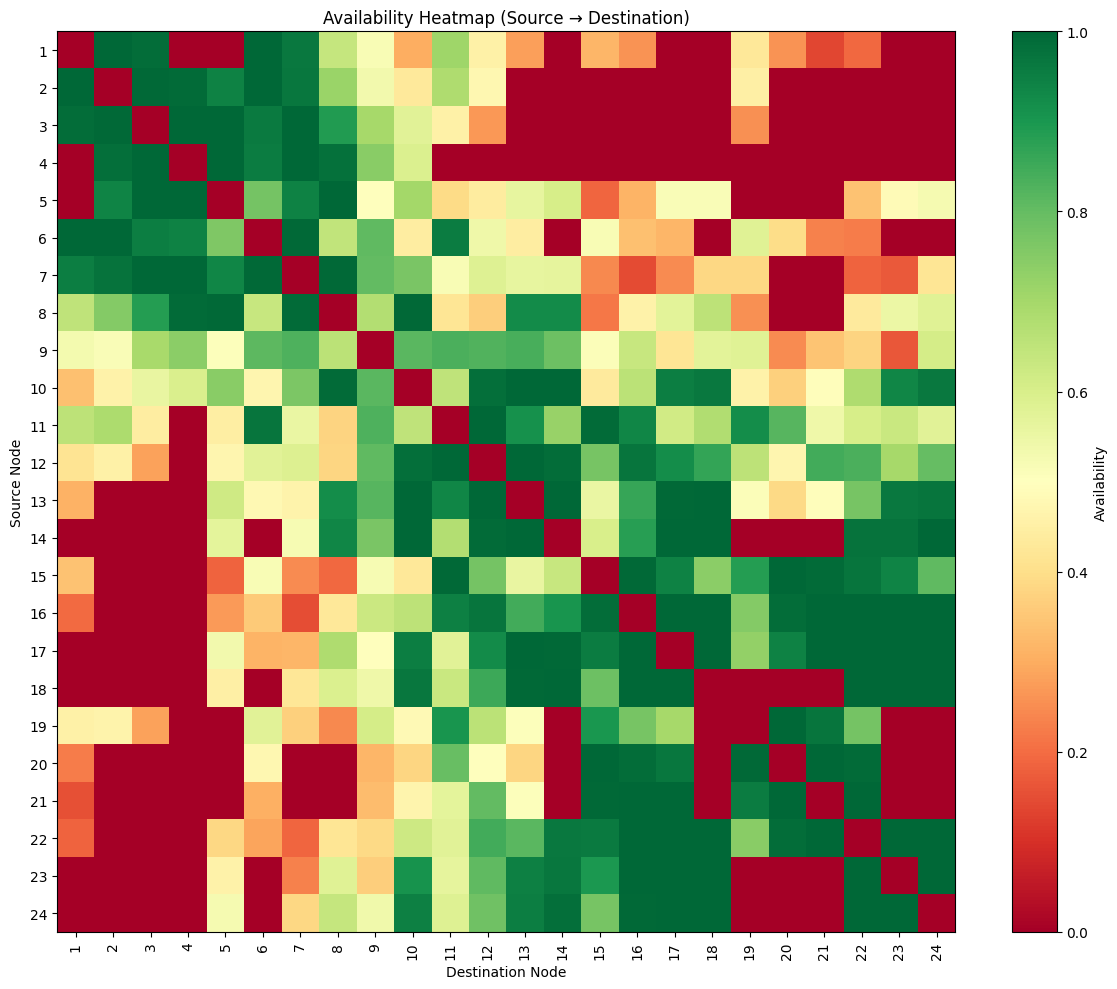

In [20]:
visualization.availability_plots.plot_availability_heatmap(dataframe1, TOPOLOGY)

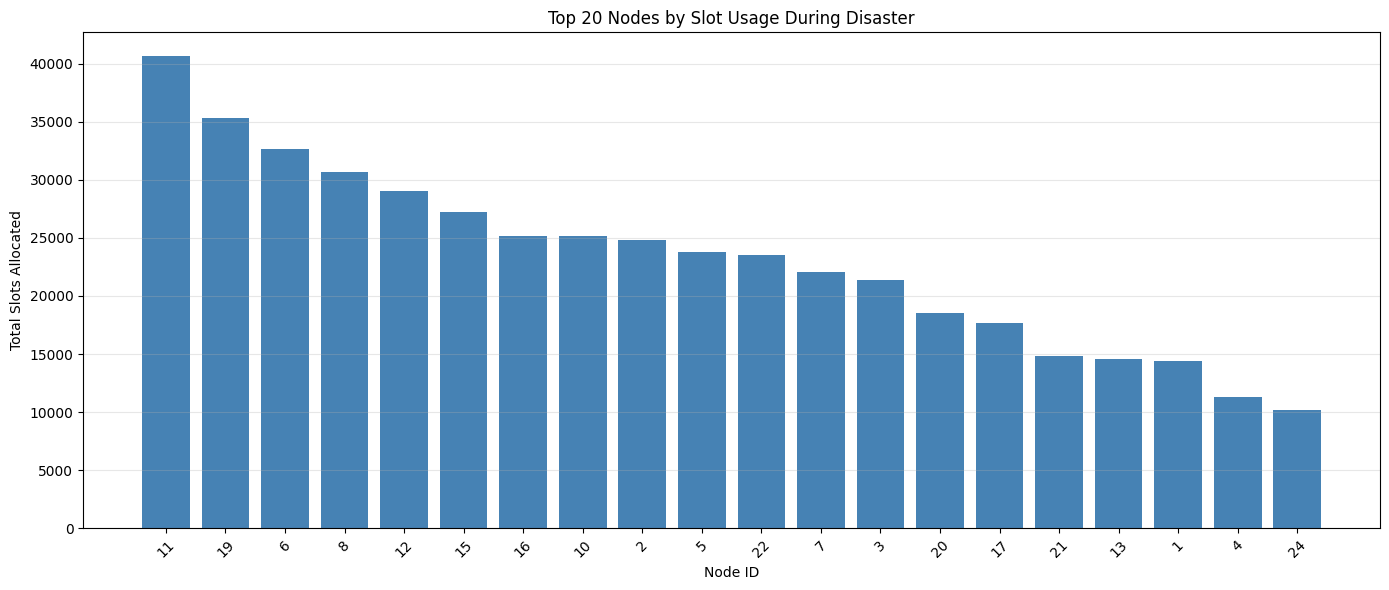

In [21]:
traffic_plots.plot_slots_per_node_during_disaster(dataframe1, DISASTER_START, DISASTER_END)

plt.show()


In [22]:
numero_de_slots_dataframe1 = metrics_calculator.get_slots_allocated_during_disaster(dataframe1, DISASTER_START, DISASTER_END)
numero_de_slots_dataframe2 = metrics_calculator.get_slots_allocated_during_disaster(dataframe2, DISASTER_START, DISASTER_END)
print("numero de slots dataframe1", numero_de_slots_dataframe1)
print("numero de slots dataframe2", numero_de_slots_dataframe2)

NameError: name 'metrics_calculator' is not defined

Considerar fazer uma sliding window por distancia de par de nodes e considerar implementar bloqueio artificial em trafego intracomponente de maneira a facilitar alocação extra componente

analise comparativa de numero de slots alocados por node
